<a href="https://colab.research.google.com/github/tnusser/SensorimotorClassifier/blob/master/SensorimotorRegressorConceptNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Package Installation

In [1]:
!pip install regressors

  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12374 sha256=4170cd4979c6aaf5a9932b5ef309026149980f0531caba2fadacc23ba6eded7c
  Stored in directory: /root/.cache/pip/wheels/b2/89/fc/7867f77234d0033395f7ad9814f245b337139acaa06b085aa2
Successfully built regressors


## Imports

In [2]:
import csv
import pandas as pd
import numpy as np
import ast

import gzip
import shutil

import matplotlib.pyplot as plt
from regressors import stats

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

## Functions

In [3]:
def parse_to_dict(file_path):
    """
    Creates hashmap with word as key and concept vector as value
    :param file_path: path to the conceptnet dictionary file
    :return: hashmap of word and vectors
    """
    concept_hash = {}
    with open(file_path, encoding="utf8") as f:
        text = f.readlines()[1:]
        for line in text:
            first_item = line.split(" ").__getitem__(0)
            concept_hash[first_item] = line
    f.close()
    return concept_hash

def find_word(embedding, word, dictionary, mode=None):
    """
    Finds embedding vector for a word in the conceptnet hashmap
    :param word: input word to analyze
    :param concept_hash: hashmap of word and conceptnet vector
    :return: returns the appropriate vector or none if its not in the hashmap
    """
    if embedding == "conceptnet":
      if word in dictionary.keys():
          vector = dictionary[word].split(" ")[1:]
          vector = [float(i) for i in vector]
      else:
          vector = []
    if embedding == "bert":
      bert_vec = bert_embedding([word])[0][1]
      if mode == "add":
        vector = np.asarray([sum(x) for x in zip(*bert_vec)])
    return vector

def from_np_array(array_string):
    """
    Converts string array from imported csv to an actual
    numpy array
    :array_string input string which can be represented as np array
    """
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

## Preprocessing

In [4]:
# Sensorimotor Dataset
!wget -O "data.csv" "https://osf.io/48wsc/download"

# ConceptNet Word Embeddings
!wget https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-en-19.08.txt.gz

--2020-09-01 15:40:37--  https://osf.io/48wsc/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.de-1.osf.io/v1/resources/rwhs6/providers/osfstorage/5cc2d6441906ec0017056ba8?action=download&direct&version=1 [following]
--2020-09-01 15:40:38--  https://files.de-1.osf.io/v1/resources/rwhs6/providers/osfstorage/5cc2d6441906ec0017056ba8?action=download&direct&version=1
Resolving files.de-1.osf.io (files.de-1.osf.io)... 35.186.249.111
Connecting to files.de-1.osf.io (files.de-1.osf.io)|35.186.249.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17196336 (16M) [text/csv]
Saving to: ‘data.csv’

data.csv            100%[===================>]  16.40M  4.98MB/s    in 3.3s    

2020-09-01 15:40:44 (4.98 MB/s) - ‘data.csv’ saved [17196336/17196336]

--2020-09-01 15:40:45--  https://conceptnet.s3.amazonaws.com/downloads/2019/numberbat

In [5]:
with gzip.open("numberbatch-en-19.08.txt.gz",'rb') as f_in:
    with open('numberbatch-en.txt','wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
concept_hash = parse_to_dict("numberbatch-en.txt")

In [6]:
df = pd.read_csv("data.csv", usecols=["Word", "Auditory.mean", "Gustatory.mean", "Haptic.mean", "Interoceptive.mean", "Olfactory.mean", "Visual.mean"])
df.columns = ["word", "auditory", "gustatory", "haptic", "interoceptive", "olfactory", "visual"]
df["word"] = df["word"].str.lower()
df['word'] = df['word'].str.replace(' ','_')
df.head()

,word,auditory,gustatory,haptic,interoceptive,olfactory,visual
0,a,2.214286,0.000000,0.428571,0.000000,0.000000,2.428571
1,a_cappella,4.333333,0.000000,0.222222,0.722222,0.000000,1.666667
2,aardvark,1.625000,0.562500,1.625000,0.062500,1.250000,4.125000
3,aback,1.294118,0.058824,0.294118,1.352941,0.000000,2.823529
4,abacus,1.555556,0.166667,3.722222,0.277778,0.111111,3.944444


In [7]:
df.describe()

,auditory,gustatory,haptic,interoceptive,olfactory,visual
count,39707.000000,39707.000000,39707.000000,39707.000000,39707.000000,39707.000000
mean,1.513996,0.323886,1.074025,1.032225,0.389891,2.897181
std,0.990793,0.696873,0.934217,0.880474,0.619021,0.902461
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.733333,0.000000,0.363636,0.375000,0.052632,2.263158
50%,1.384615,0.117647,0.769231,0.777778,0.187500,2.937500
75%,2.117647,0.300000,1.562500,1.444444,0.437500,3.588235
max,5.000000,5.000000,4.944444,4.900000,5.000000,5.000000


In [8]:
vecs = []
df["max_val"] = df.iloc[:,1:7].idxmax(axis=1)
for index, row in df.iterrows():
    word_vec = find_word(embedding="conceptnet", word=row['word'], dictionary=concept_hash)
    if word_vec == []:
        df.drop(index, inplace=True)
    else:
        vecs.append(word_vec)
df["vec"] = vecs
df.head()

,word,auditory,gustatory,haptic,interoceptive,olfactory,visual,max_val,vec
0,a,2.214286,0.000000,0.428571,0.000000,0.000000,2.428571,visual,"[-0.1011, -0.0806, -0.0092, 0.0901, -0.0323, -..."
2,aardvark,1.625000,0.562500,1.625000,0.062500,1.250000,4.125000,visual,"[0.0341, 0.0697, 0.0826, -0.0504, -0.1586, 0.0..."
3,aback,1.294118,0.058824,0.294118,1.352941,0.000000,2.823529,visual,"[-0.0821, -0.0935, 0.0306, -0.0153, 0.0239, -0..."
4,abacus,1.555556,0.166667,3.722222,0.277778,0.111111,3.944444,visual,"[-0.0015, 0.0511, -0.0005, 0.0978, -0.1432, -0..."
5,abandon,0.941176,0.117647,0.294118,2.117647,0.058824,2.176471,visual,"[-0.1269, -0.1875, -0.0127, -0.0012, 0.1389, 0..."


In [9]:
df.describe()

,auditory,gustatory,haptic,interoceptive,olfactory,visual
count,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000
mean,1.518045,0.325248,1.074665,1.034313,0.391868,2.900529
std,0.992396,0.699326,0.932906,0.881571,0.621650,0.902145
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.733333,0.000000,0.368421,0.375000,0.052632,2.266667
50%,1.388889,0.117647,0.769231,0.785714,0.187500,2.941176
75%,2.117647,0.304348,1.562500,1.450000,0.437500,3.588235
max,5.000000,5.000000,4.944444,4.900000,5.000000,5.000000


## Train Test Split

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(np.stack(df.vec, axis=0), df, test_size=0.2, random_state=43)
 print(X_train.shape)
 print(X_test.shape)

(31097, 300)
(7775, 300)


## Regression models

In [ ]:
reg_alg = [LinearRegression(), Lasso(alpha=0.00001), GradientBoostingRegressor(verbose=1, n_estimators=350)]
scores = []
for reg in reg_alg:
  mses, maes = [], []
  for i in range(6):
    model = reg.fit(X_train, y_train.iloc[:,i+1])
    mse = mean_squared_error(model.predict(X_test), y_test.iloc[:,i+1], squared=False)
    mae = mean_absolute_error(model.predict(X_test), y_test.iloc[:,i+1])
    mses.append(mse)
    maes.append(mae)
  scores.append((np.mean(maes), maes, np.mean(mses), mses))
print(scores)

      Iter       Train Loss   Remaining Time 
         1           0.9368           21.79m
         2           0.8982           21.67m
         3           0.8652           21.60m
         4           0.8389           21.50m
         5           0.8147           21.47m
         6           0.7934           21.42m
         7           0.7758           21.39m
         8           0.7600           21.32m
         9           0.7452           21.24m
        10           0.7304           21.18m
        20           0.6341           20.46m
        30           0.5806           19.77m
        40           0.5450           19.13m
        50           0.5181           18.48m
        60           0.4976           17.84m
        70           0.4812           17.22m
        80           0.4678           16.61m
        90           0.4551           15.98m
       100           0.4445           15.36m
       200           0.3800            9.21m
       300           0.3450            3.07m
      Ite

In [ ]:
# To calculate the p-values of beta coefficients: 
print("coef_pval:\n", stats.coef_pval(reg, X_test, y_test.haptic))

# to print summary table:
print("\n=========== SUMMARY ===========")
xlabels = df.columns[1:7]
stats.summary(reg, X_test, y_test.haptic)

In [ ]:
 xtrain, xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.1, random_state=43)

## Neural Network

In [ ]:
model = models.Sequential()
model.add(layers.Dense(300, activation='relu' ,input_shape=(300,)))
model.add(keras.layers.Dropout(0.4))
model.add(layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse', 'mae'])
print(model.summary())
filepath="weights.best.hdf5"
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                9632      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 99,965
Trainable params: 99,965
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
mses, maes = [], []
for i in range(6):
    history = model.fit(xtrain, ytrain.iloc[:,i+1], epochs=50, batch_size=512, validation_data=(xval, yval.iloc[:,i+1]), verbose=1, callbacks=[es_callback])
    test_predict = model.predict(X_test).flatten()
    mae = mean_absolute_error(test_predict, y_test.iloc[:,i+1])
    mse = mean_squared_error(test_predict, y_test.iloc[:,i+1], squared=False)
    mses.append(mse)
    maes.append(mae)
scores.append((np.mean(maes), maes, np.mean(mses), mses))
for s in scores:
  print(s[0])

Epoch 1/50
55/55 [==============================] - 1s 12ms/step - loss: 1.3789 - mse: 1.3789 - mae: 0.9015 - val_loss: 0.5827 - val_mse: 0.5827 - val_mae: 0.6003
Epoch 2/50
55/55 [==============================] - 1s 10ms/step - loss: 0.5400 - mse: 0.5400 - mae: 0.5773 - val_loss: 0.4391 - val_mse: 0.4391 - val_mae: 0.5129
Epoch 3/50
55/55 [==============================] - 1s 10ms/step - loss: 0.4712 - mse: 0.4712 - mae: 0.5304 - val_loss: 0.4127 - val_mse: 0.4127 - val_mae: 0.4975
Epoch 4/50
55/55 [==============================] - 1s 10ms/step - loss: 0.4433 - mse: 0.4433 - mae: 0.5141 - val_loss: 0.3989 - val_mse: 0.3989 - val_mae: 0.4873
Epoch 5/50
55/55 [==============================] - 1s 11ms/step - loss: 0.4246 - mse: 0.4246 - mae: 0.5015 - val_loss: 0.3891 - val_mse: 0.3891 - val_mae: 0.4806
Epoch 6/50
55/55 [==============================] - 1s 16ms/step - loss: 0.4079 - mse: 0.4079 - mae: 0.4901 - val_loss: 0.3807 - val_mse: 0.3807 - val_mae: 0.4727
Epoch 7/50
55/55 [====

## Training Loss plot

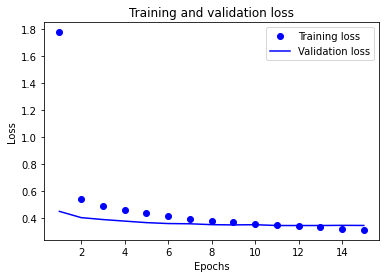

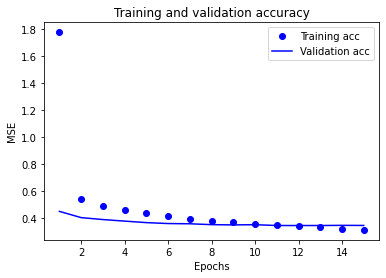

In [ ]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['mse']
val_acc_values = history_dict['val_mse']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Results

In [ ]:
algs = ["Linear Regression", "Ridge Regression", "Gradient Boosting Regressor", "Neural Network"]

for i, s in enumerate(scores):
  print("Algorithm:", algs[i])
  print("Mean Squared Error: "  , s[2])
  print("Individual MSE scores: ") 
  print(s[3])
  print("Mean Average Error: " , s[0])
  print("Individual MAE scores: ") 
  print(s[1])
  print("\n\n")

Algorithm: Linear Regression
Mean Squared Error:  0.5369598589840622
Individual MSE scores: 
[0.6295360433159926, 0.4012604652135086, 0.5931463125225931, 0.5438411742805315, 0.4089642146451524, 0.6450109439265954]
Mean Average Error:  0.40623758124472237
Individual MAE scores: 
[0.4955060913099205, 0.2728733188948354, 0.45321892481457304, 0.41374304508500964, 0.2897618528512396, 0.5123222545127564]



Algorithm: Ridge Regression
Mean Squared Error:  0.5369349620082696
Individual MSE scores: 
[0.6295041809708599, 0.401332043962472, 0.5930405460802377, 0.5438331974923788, 0.40886590792591937, 0.64503389561775]
Mean Average Error:  0.40608554982164885
Individual MAE scores: 
[0.49549440914939485, 0.2725729582835801, 0.45305227785956137, 0.4136683166190921, 0.2894023627819005, 0.512322974236364]



Algorithm: Gradient Boosting Regressor
Mean Squared Error:  0.5321245094627232
Individual MSE scores: 
[0.6314117950587989, 0.3803651143000292, 0.5940404668724854, 0.5458464039147981, 0.39344885